In [2]:
!pip install -U -q tensorflow_datasets


In [3]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
DATASET_PATH = 'data/'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'speech_commands_v0.02.tar.gz',
      origin="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir='data')

2428923189/2428923189 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [5]:
# Constants
SAMPLE_RATE = 16000  # All audio files are in 16kHz
AUDIO_DURATION = 1   # Each audio is 1 second
SAMPLES_PER_TRACK = SAMPLE_RATE * AUDIO_DURATION
INPUT_SHAPE = (32, 32, 1)  # Input shape for CNN after converting to Mel-spectrogram

def load_audio_files(data_path):
    """Load audio files from the dataset directory and their corresponding labels, ignoring irrelevant files."""
    labels = []
    audio_data = []

    # Get sorted list of command directories (only folders)
    commands = [d for d in sorted(os.listdir(data_path)) if os.path.isdir(os.path.join(data_path, d))]
    print(f"Commands: {commands}")

    for label, command in enumerate(commands):
        command_path = os.path.join(data_path, command)
        if os.path.isdir(command_path):
            for audio_file in os.listdir(command_path):
                file_path = os.path.join(command_path, audio_file)

                # Check if the file is an audio file
                if not audio_file.endswith(('.wav', '.mp3')): # Add other audio extensions if needed
                    continue

                # Load audio file
                y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                # Ensure all audio clips are exactly 1 second long
                if len(y) >= SAMPLES_PER_TRACK:
                    y = y[:SAMPLES_PER_TRACK]  # Trim to 1 second
                else:
                    y = np.pad(y, (0, max(0, SAMPLES_PER_TRACK - len(y))), mode='constant')

                # Convert to Mel-spectrogram
                mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=32, fmax=8000)
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                # Resize and normalize the Mel-spectrogram to fit input shape
                mel_spec_db = np.expand_dims(mel_spec_db, axis=-1) # Add a channel dimension
                mel_spec_db = tf.image.resize(mel_spec_db, (32, 32))
                mel_spec_db = mel_spec_db.numpy().reshape(32, 32, 1)  # Add channel dimension

                # Store data and label
                audio_data.append(mel_spec_db)
                labels.append(label)

    return np.array(audio_data), np.array(labels), commands

In [106]:
# Load dataset
data_path = "data"  # Path to the extracted dataset directory
audio_data, labels, commands = load_audio_files(data_path)

Commands: ['_background_noise_', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [107]:
# Normalize data
audio_data = audio_data / 255.0

In [108]:
# Split data into train, validation, and test sets
train_data, test_data, train_labels, test_labels = train_test_split(audio_data, labels, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [109]:
# Convert labels to categorical format for training
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=len(commands))
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=len(commands))
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=len(commands))

In [110]:
print(f"Train Data Shape: {train_data.shape}")


Train Data Shape: (67734, 32, 32, 1)


In [111]:
print(f"Validation Data Shape: {val_data.shape}")


Validation Data Shape: (16934, 32, 32, 1)


In [112]:
print(f"Test Data Shape: {test_data.shape}")

Test Data Shape: (21167, 32, 32, 1)


In [6]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# To display inline plots
%matplotlib inline

# Constants
DATASET_PATH = 'data/'
SAMPLE_RATE = 16000
AUDIO_DURATION = 1
SAMPLES_PER_TRACK = SAMPLE_RATE * AUDIO_DURATION


In [7]:
def plot_waveform(y, sr, title="Waveform"):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()


In [8]:
def plot_melspectrogram(y, sr, n_mels=32, fmax=8000, title="Mel-Spectrogram"):
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', fmax=fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()


In [9]:
def plot_class_distribution(labels, commands):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=labels, palette="viridis")
    plt.title('Class Distribution')
    plt.xlabel('Command')
    plt.ylabel('Count')
    plt.xticks(ticks=np.arange(len(commands)), labels=commands, rotation=45)
    plt.show()


In [10]:
import random

# Load a sample audio file from each command for visualization
def visualize_samples(data_path, commands):
    for command in commands:
        command_path = os.path.join(data_path, command)
        sample_file = random.choice(os.listdir(command_path))
        file_path = os.path.join(command_path, sample_file)

        if file_path.endswith(('.wav', '.mp3')):
            # Load audio file
            y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

            # Plot Waveform
            plot_waveform(y, sr, title=f"Waveform of {command} - {sample_file}")

            # Plot Mel-Spectrogram
            plot_melspectrogram(y, sr, title=f"Mel-Spectrogram of {command} - {sample_file}")


<ipython-input-116-3b041d10b6a4>:3: FutureWarning: 



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



  sns.countplot(x=labels, palette="viridis")


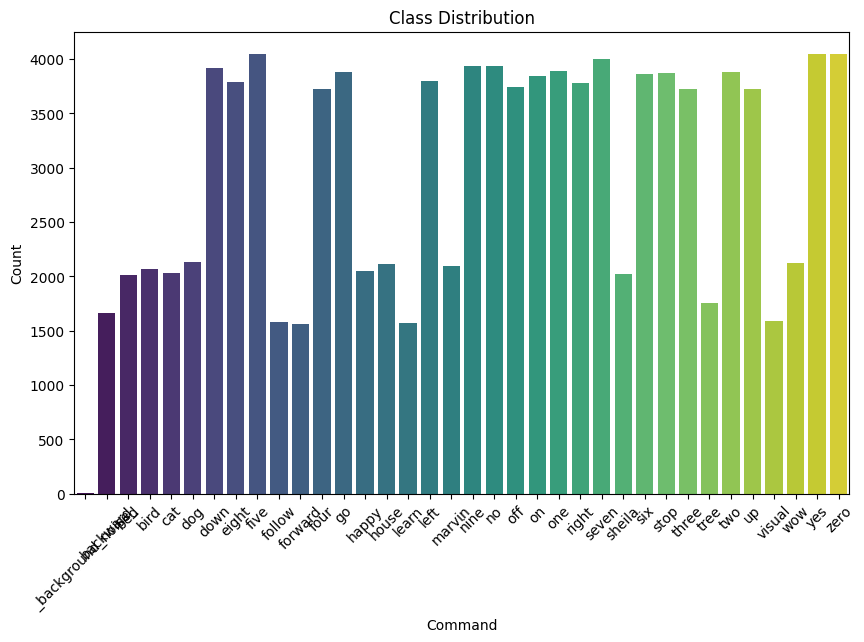

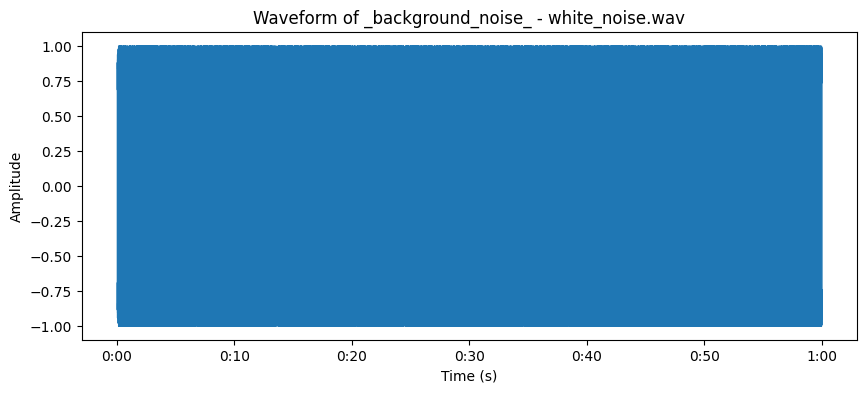

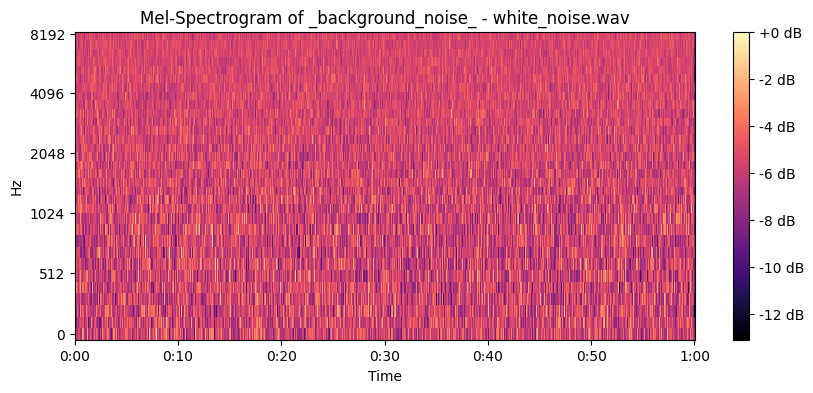

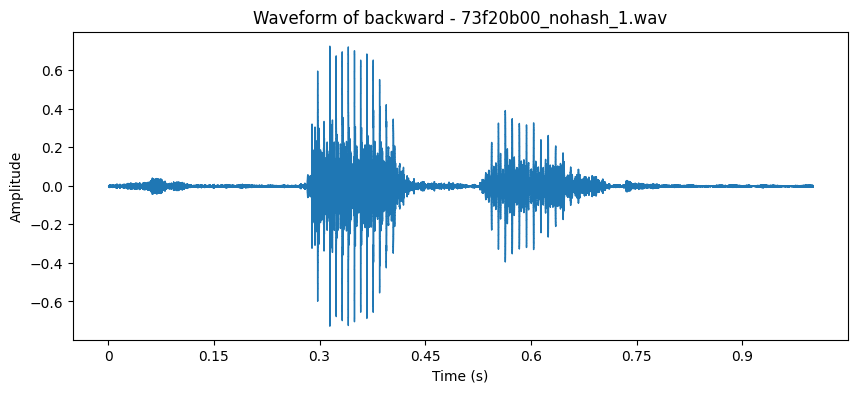

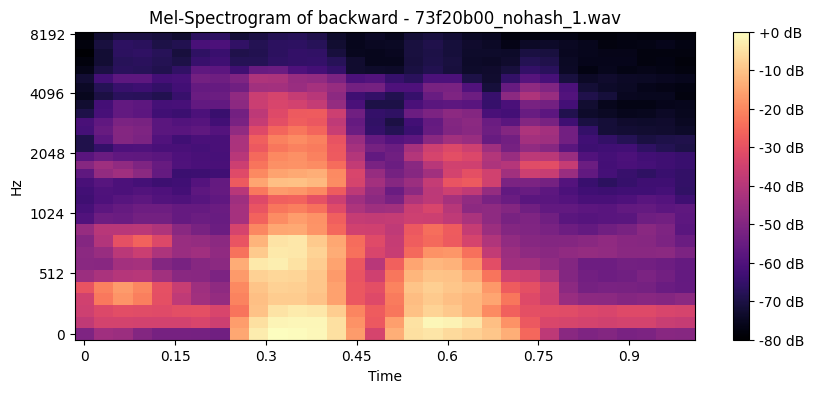

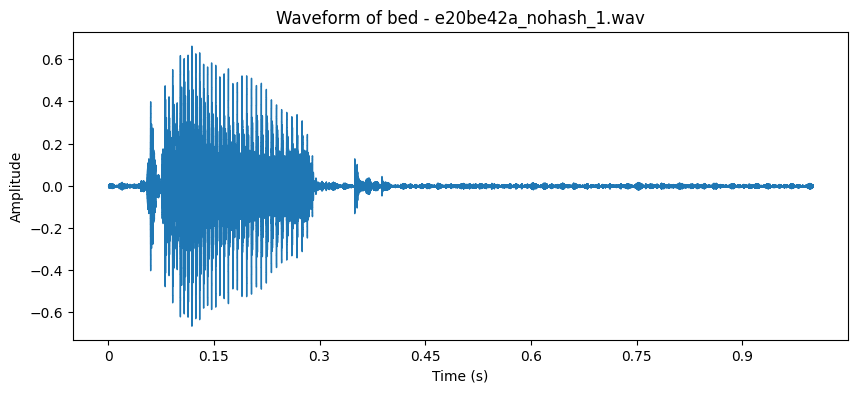

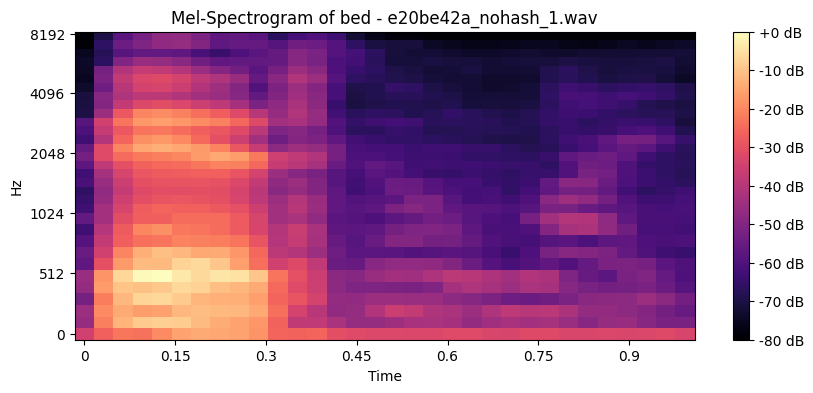

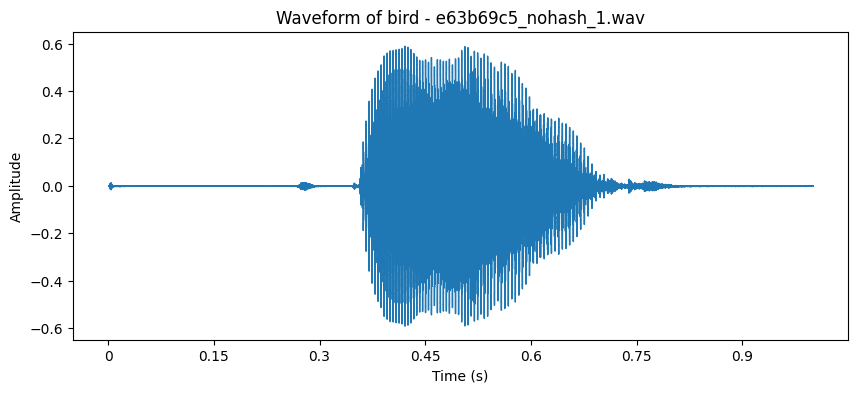

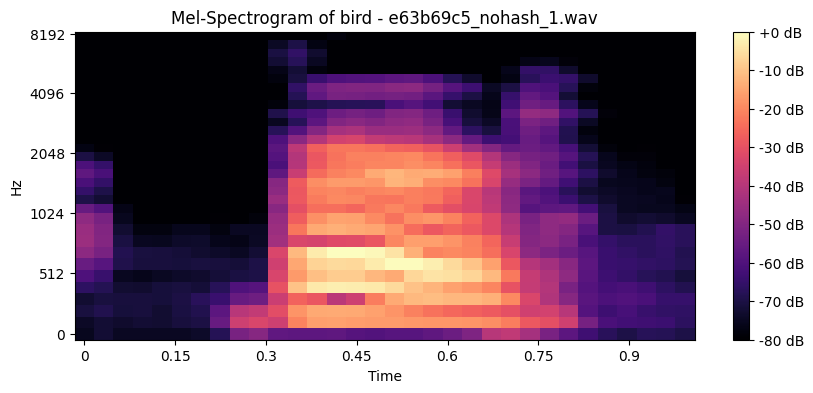

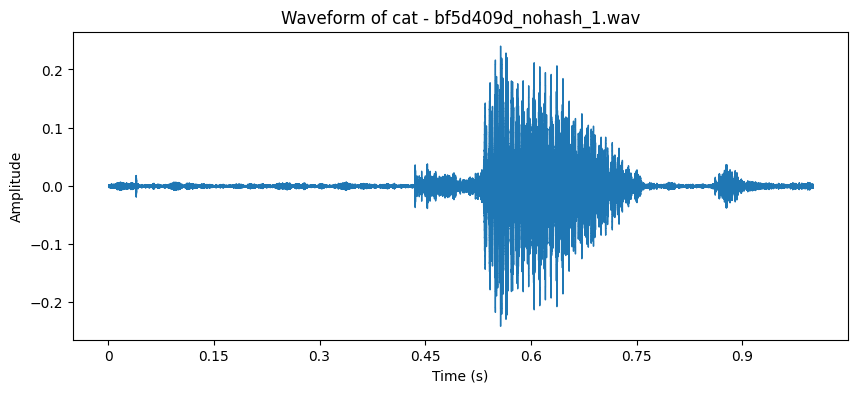

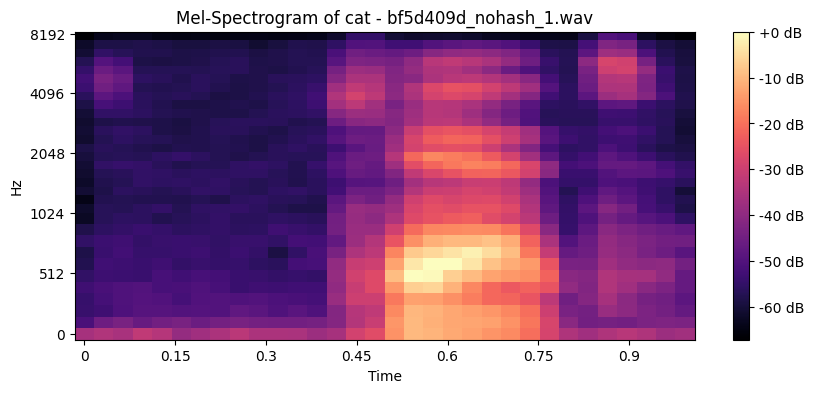

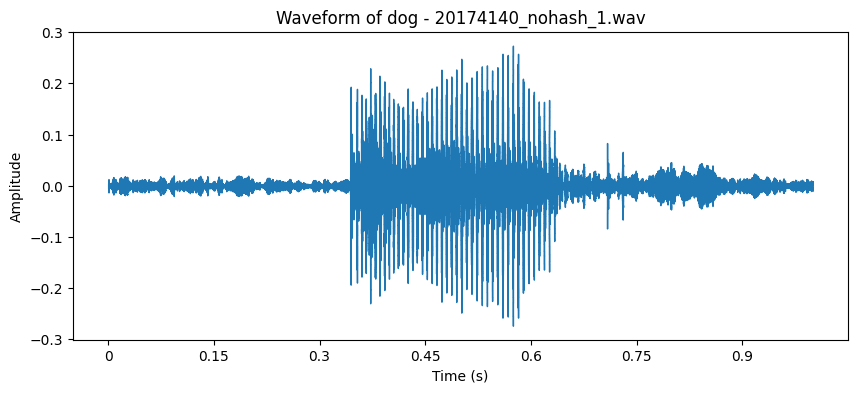

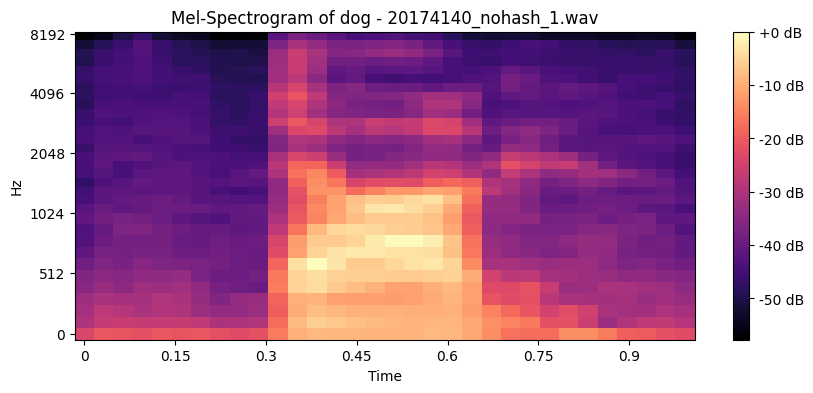

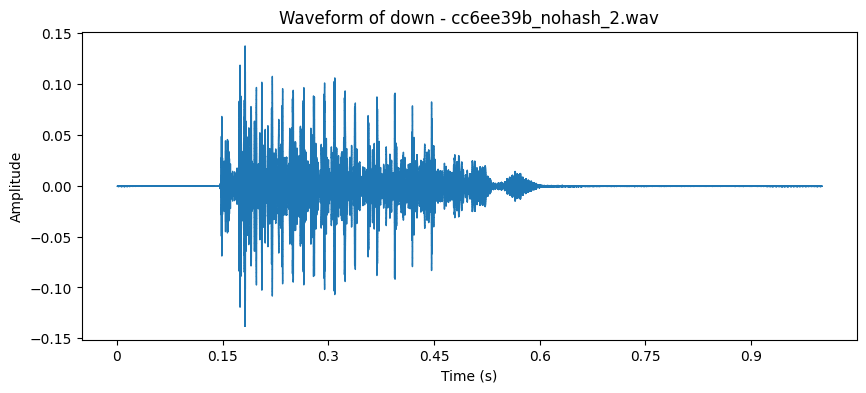

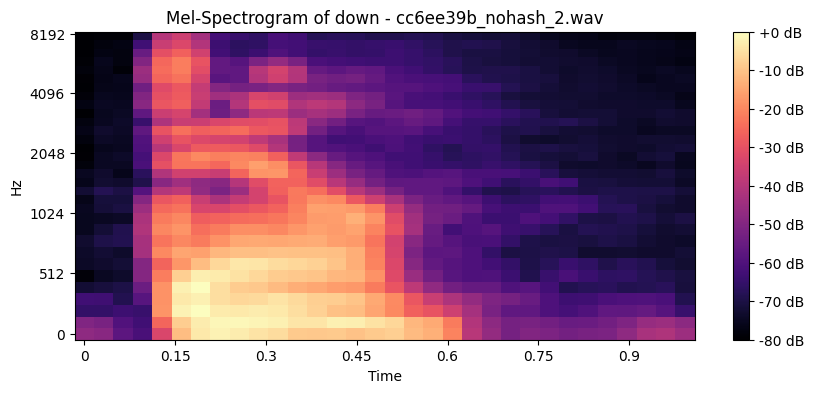

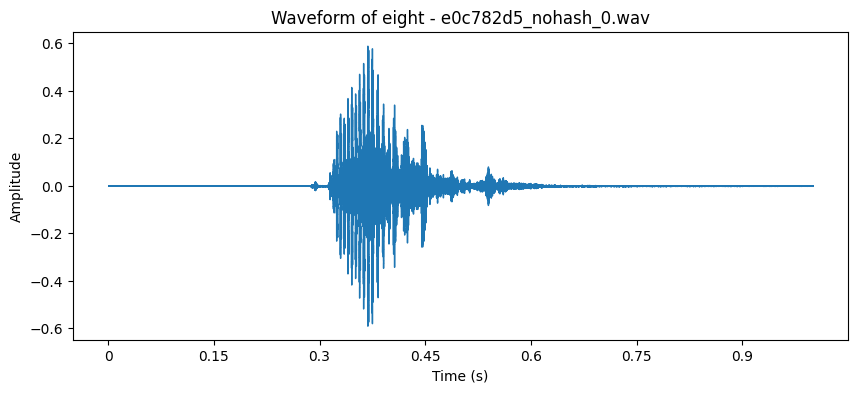

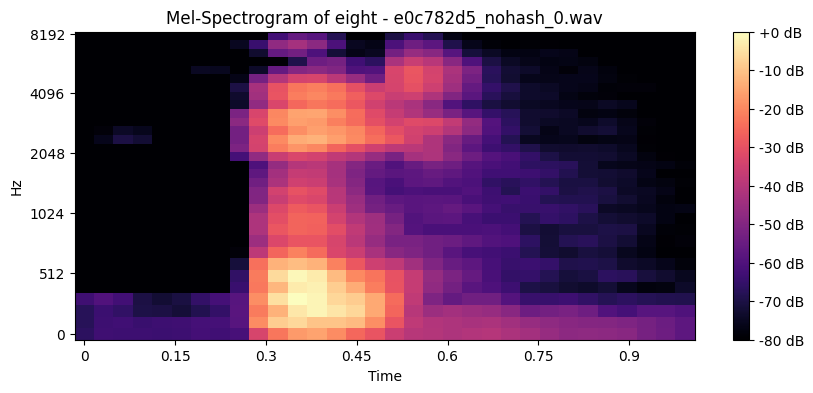

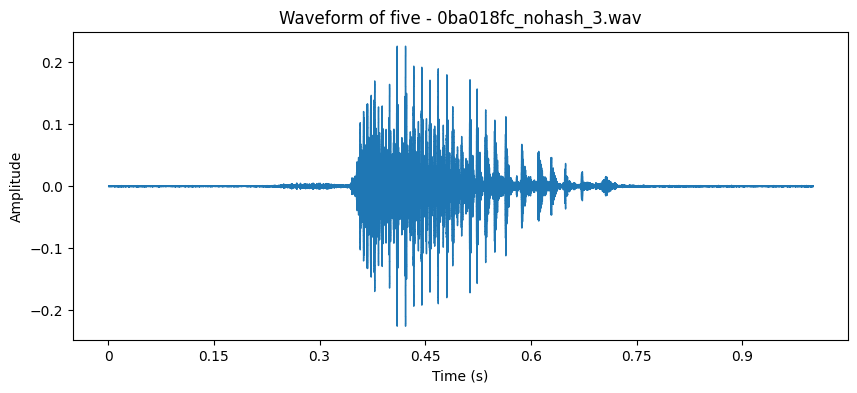

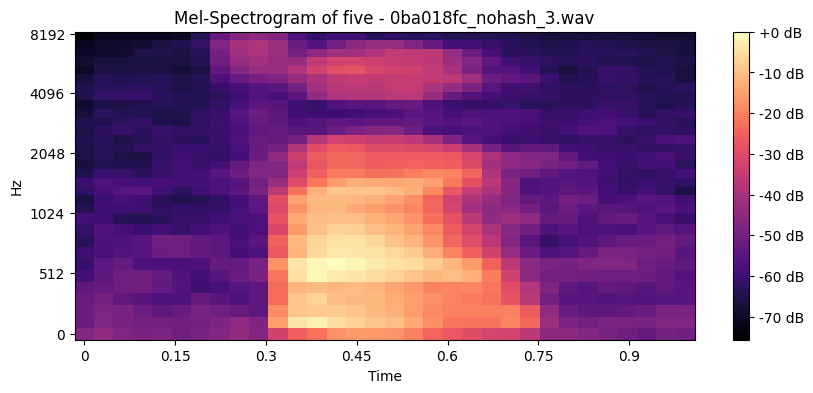

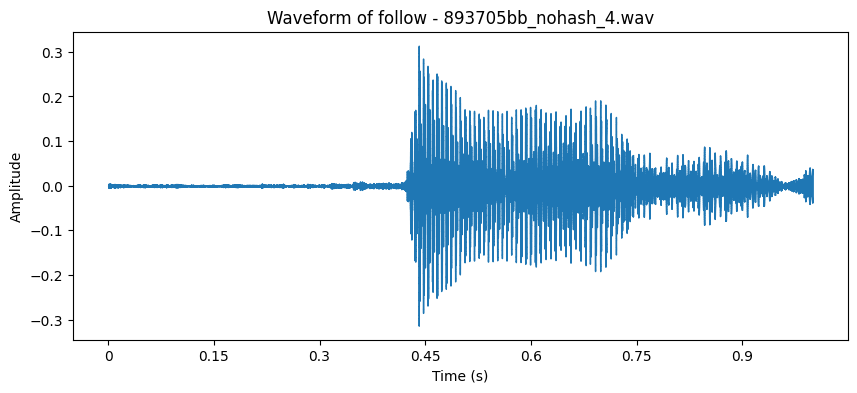

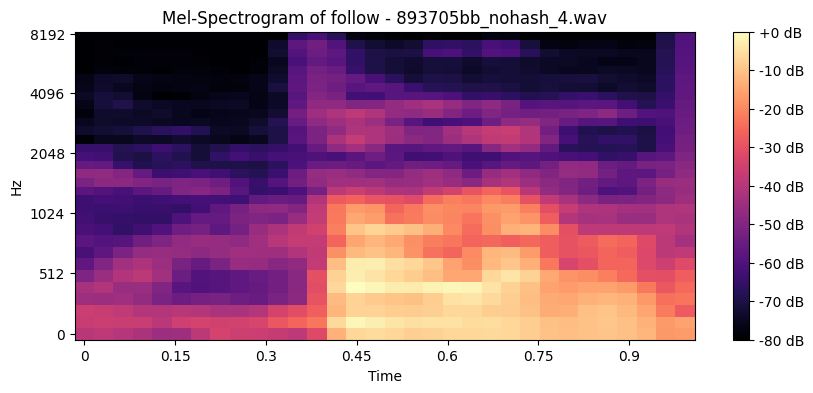

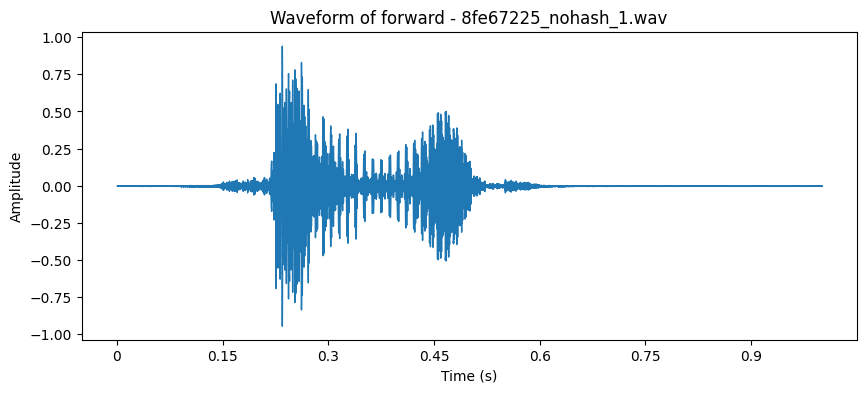

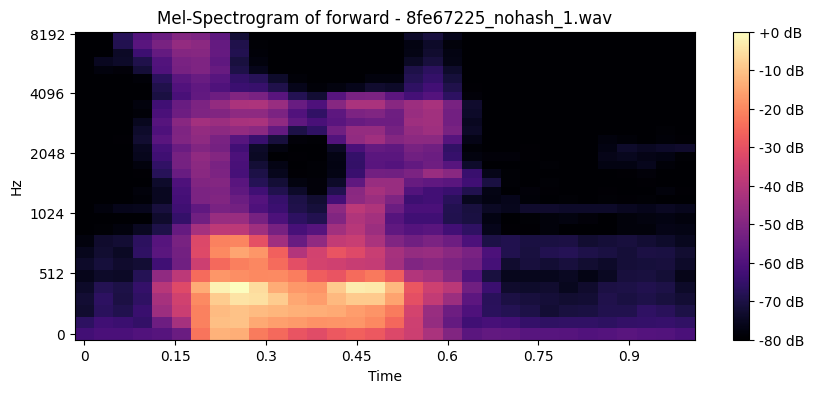

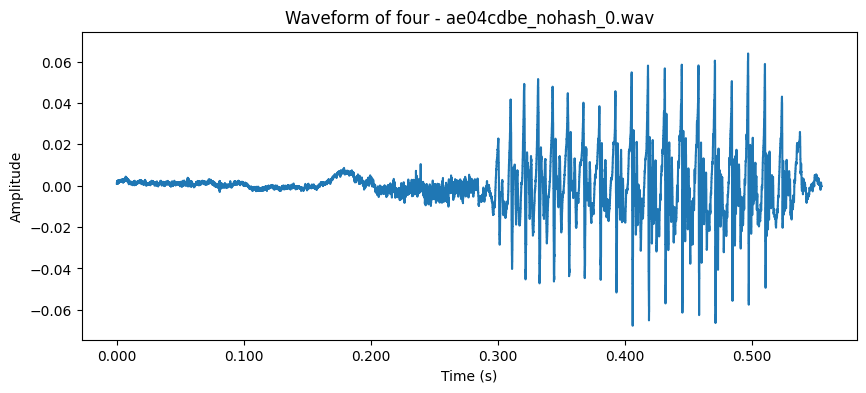

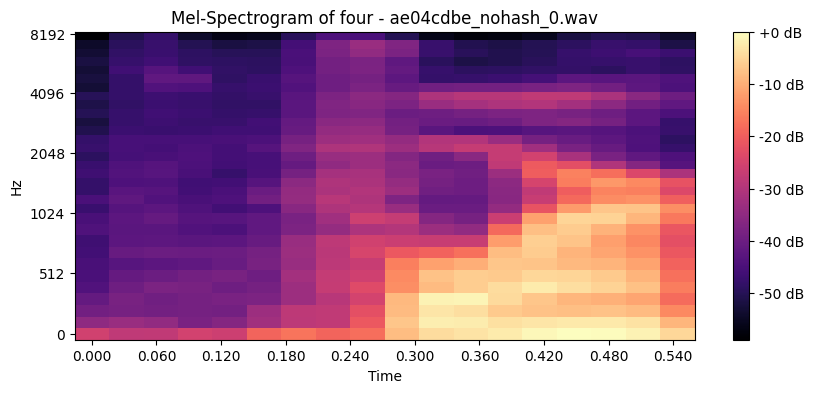

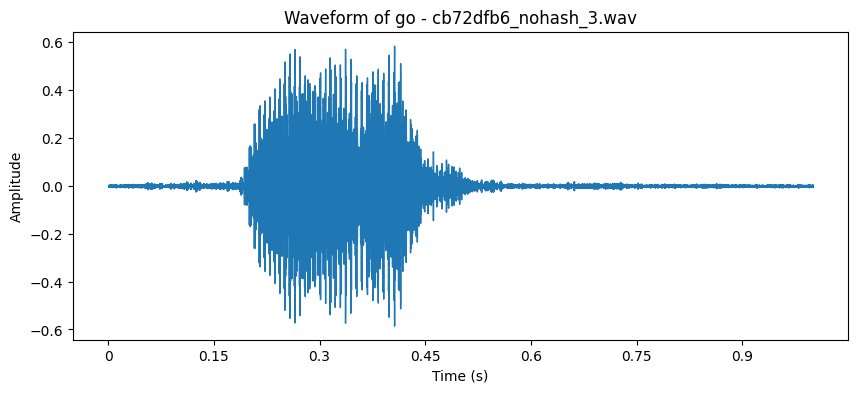

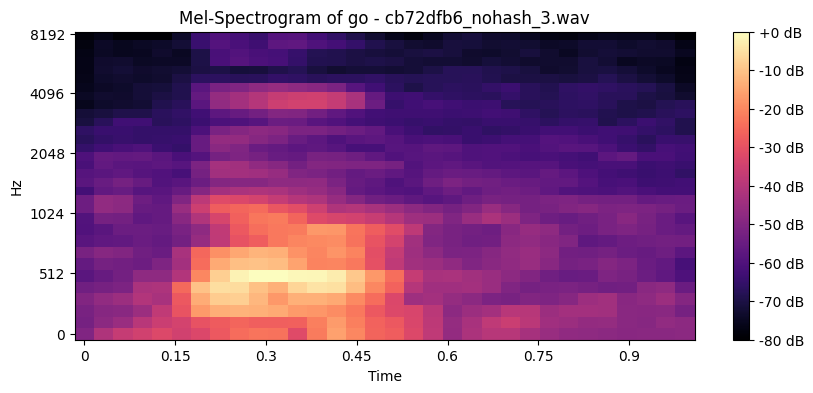

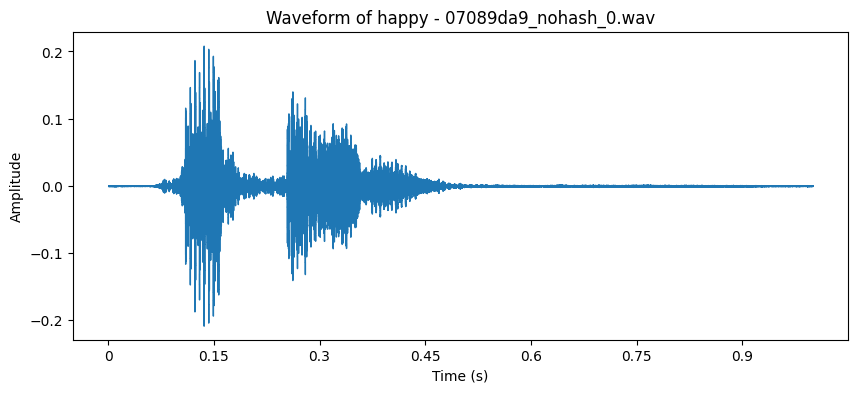

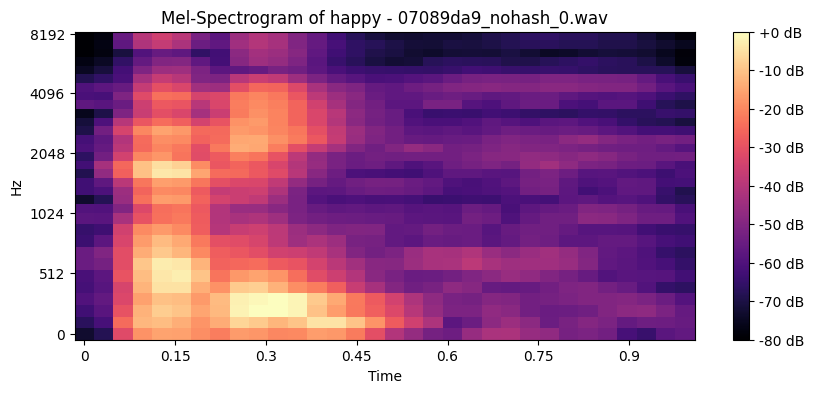

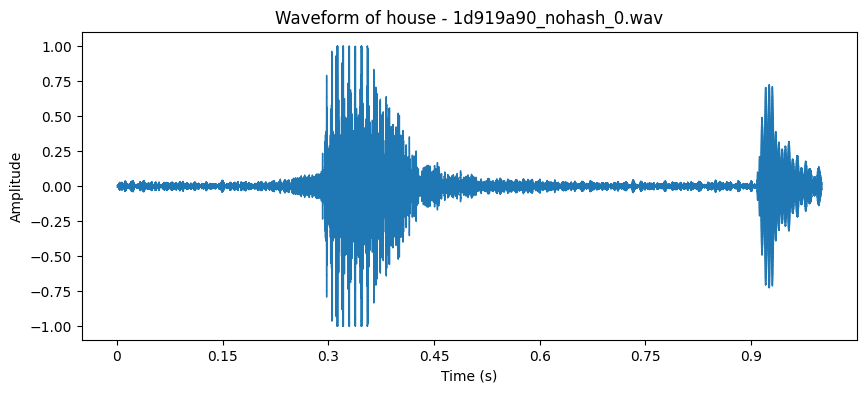

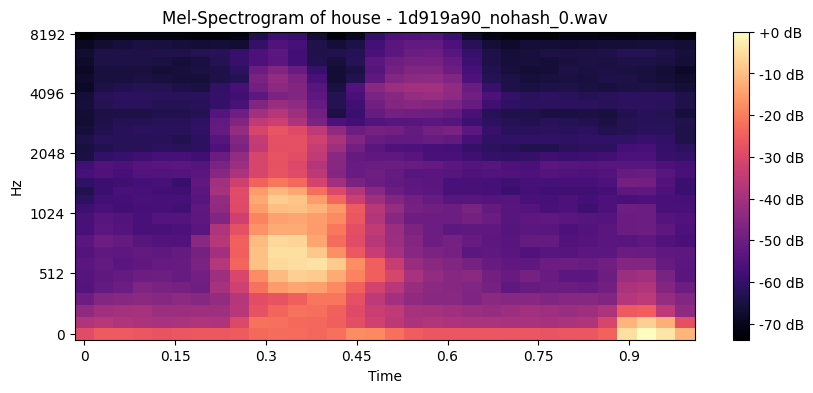

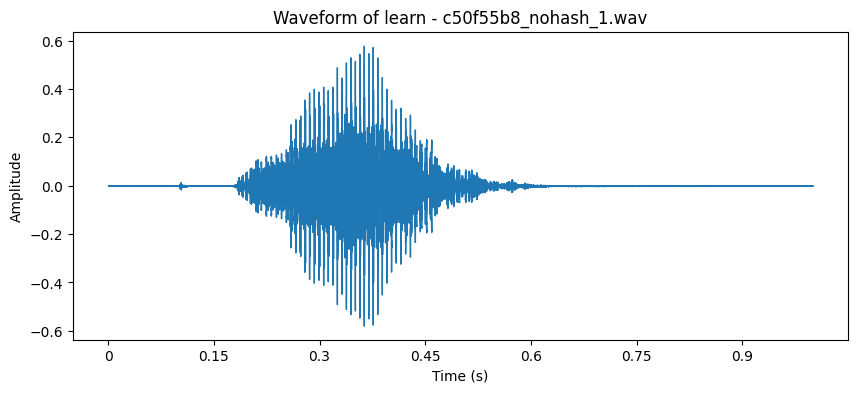

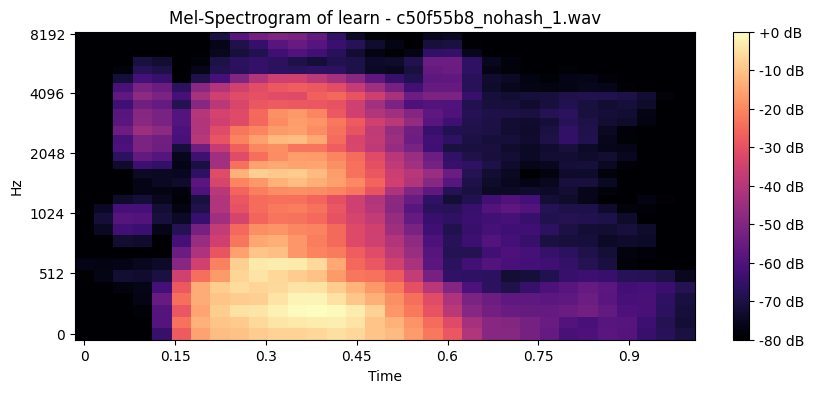

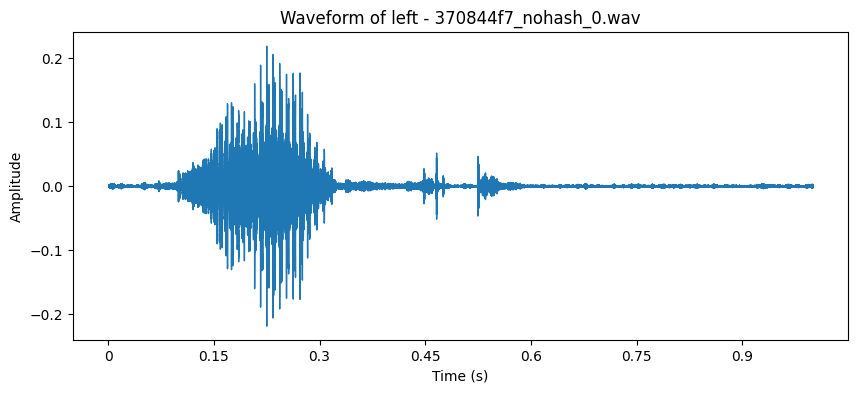

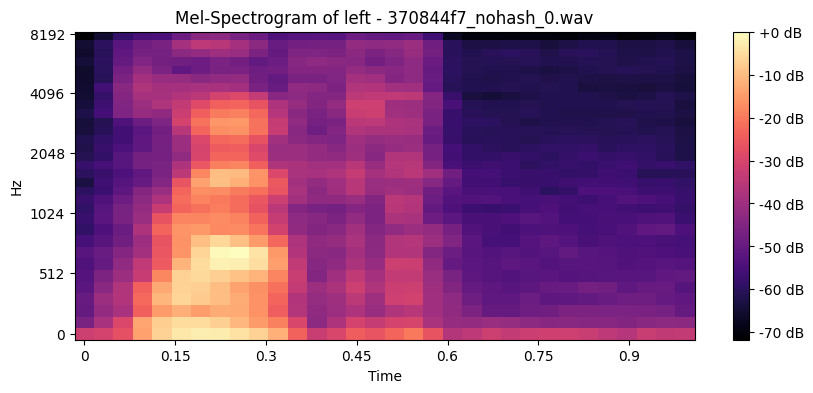

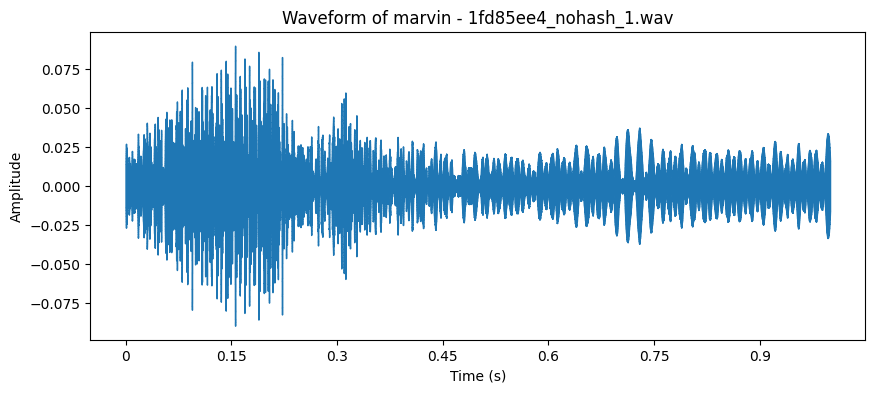

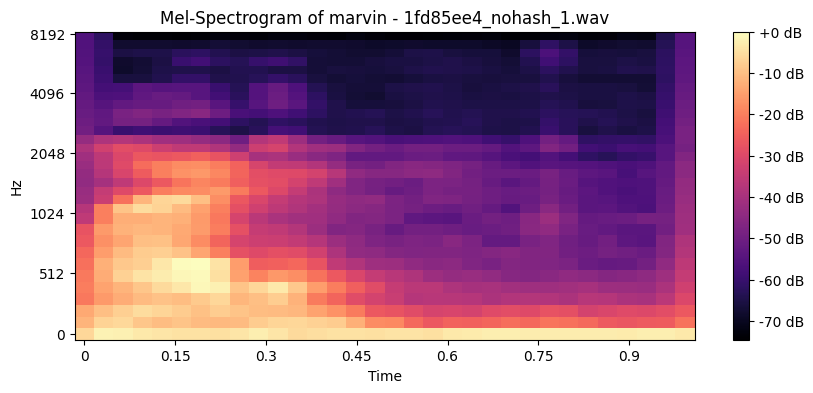

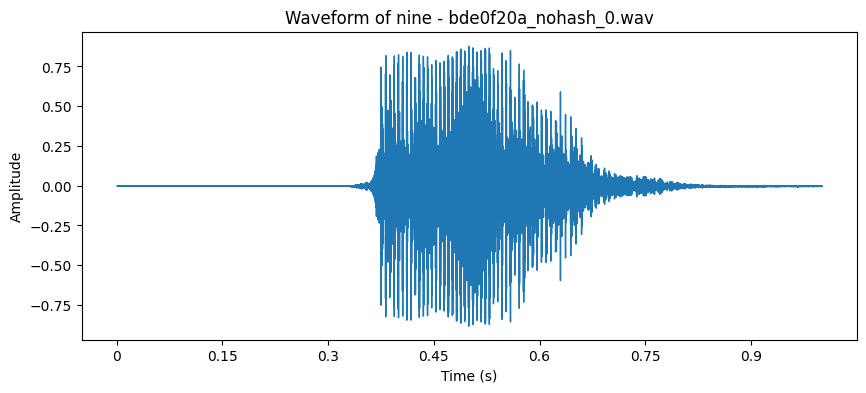

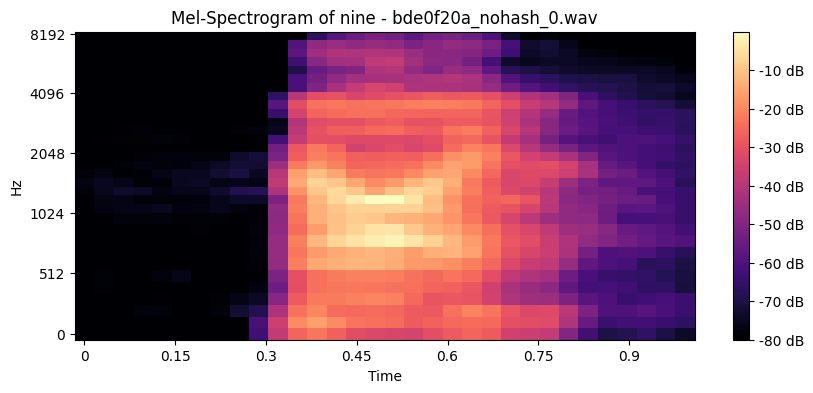

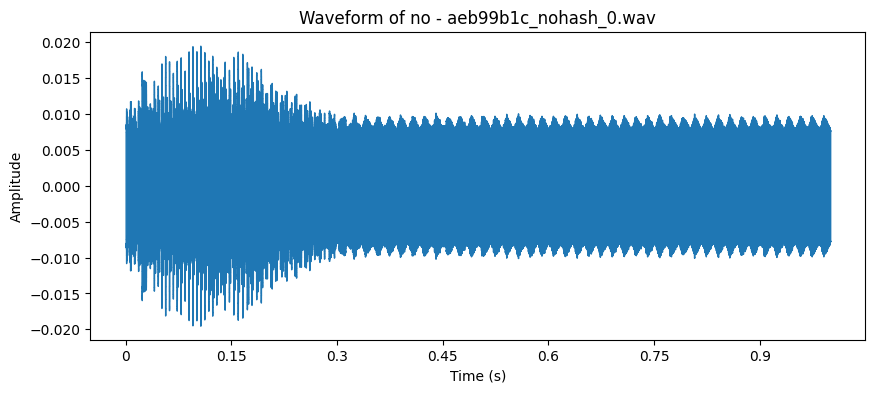

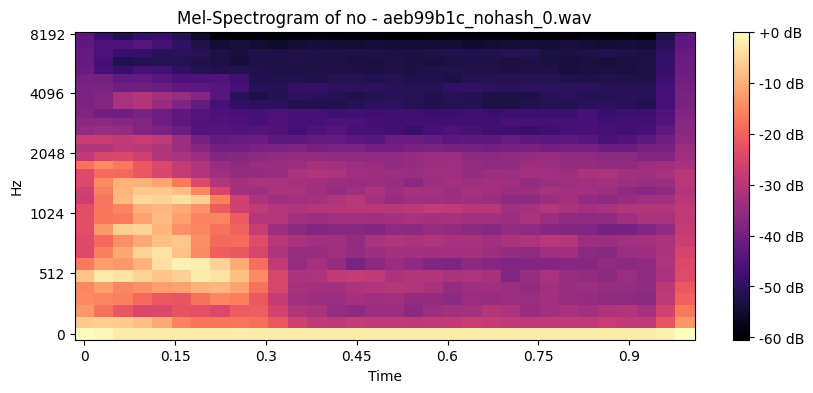

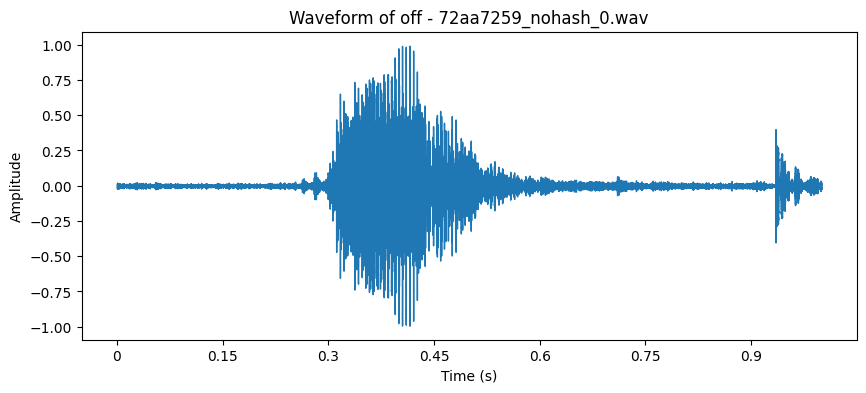

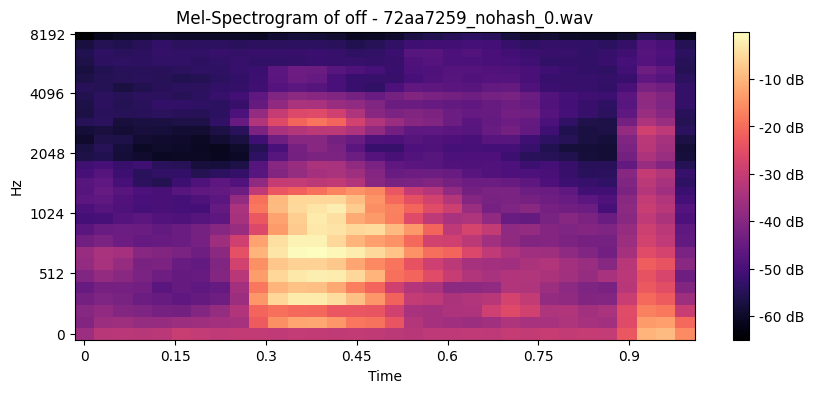

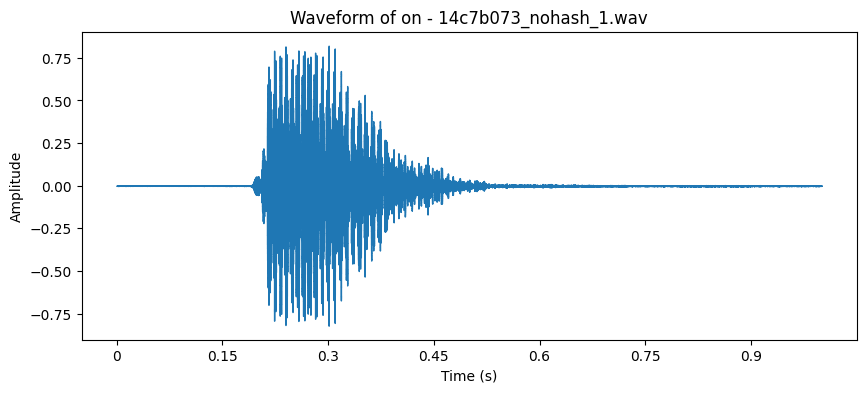

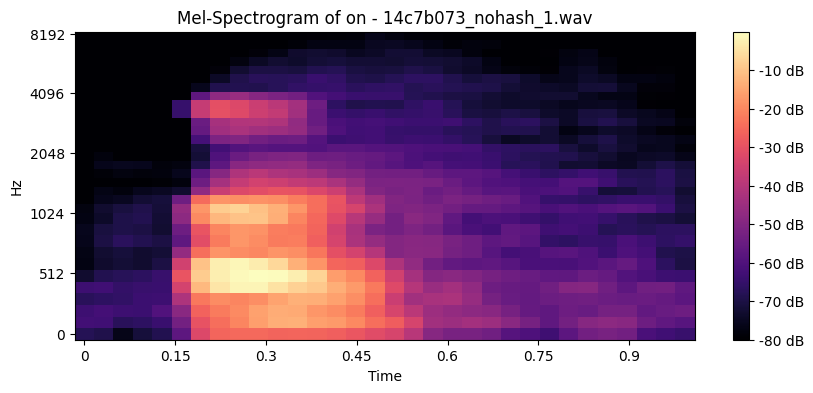

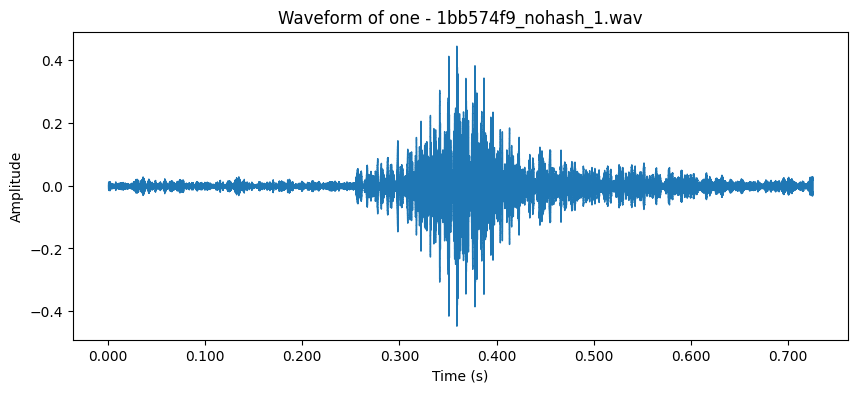

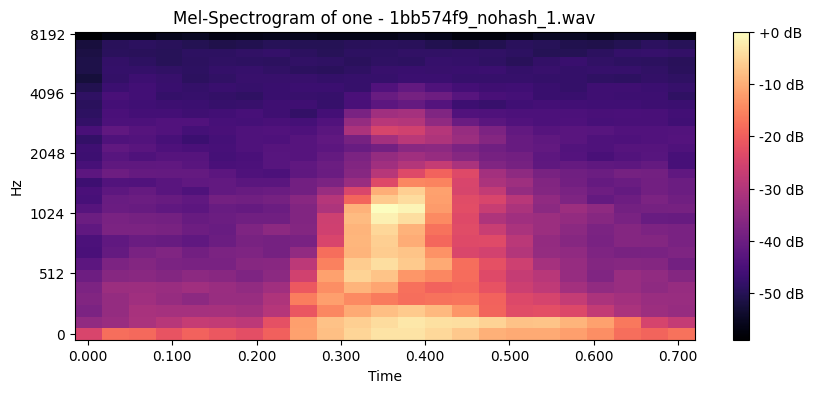

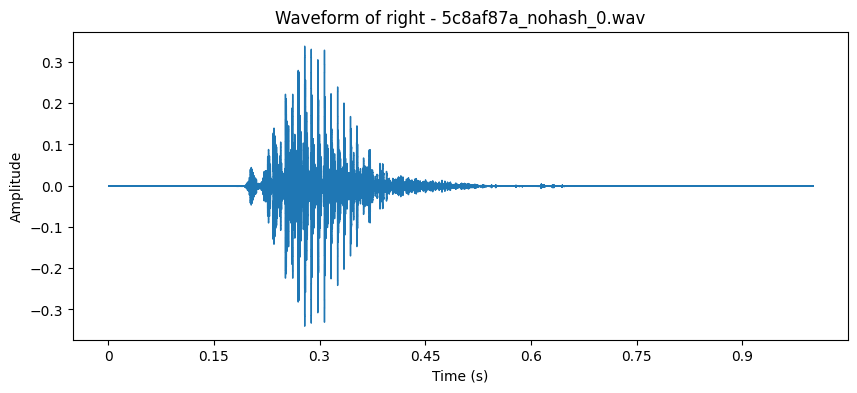

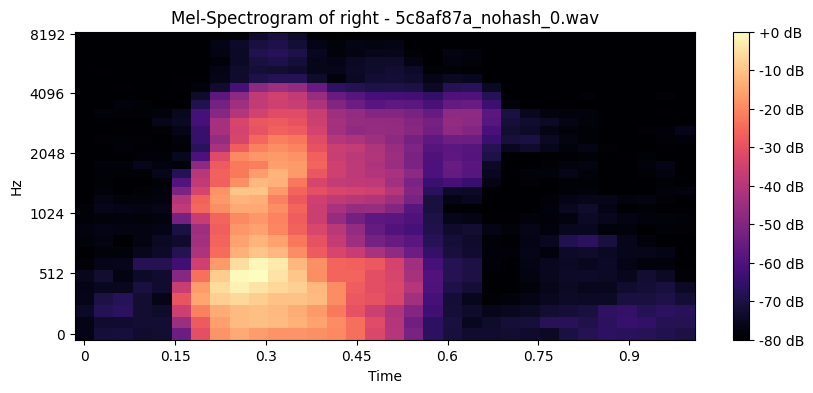

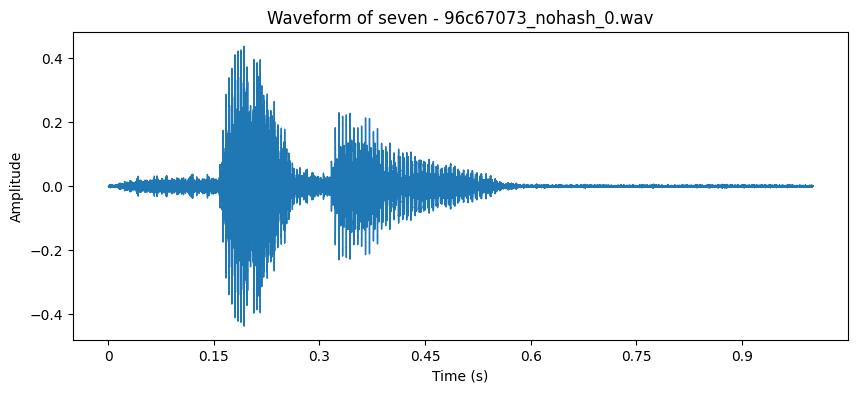

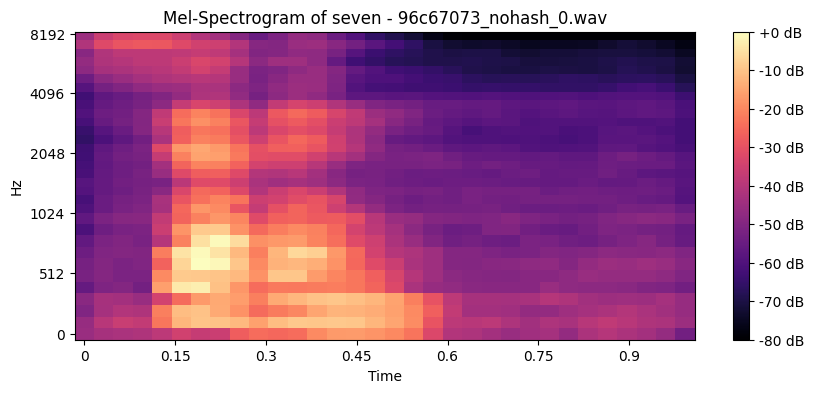

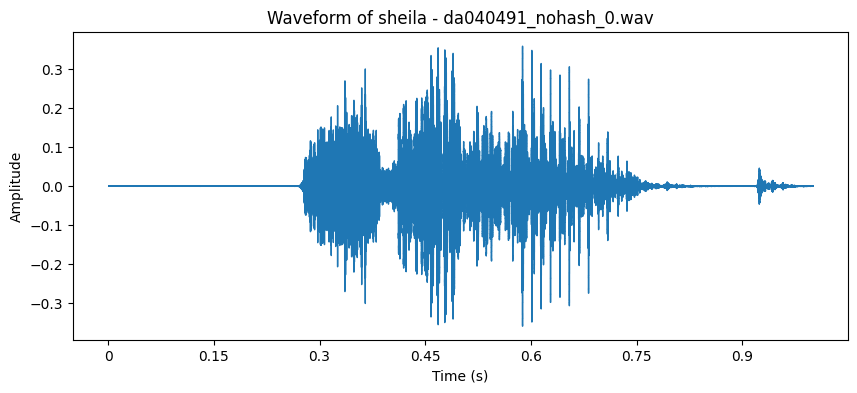

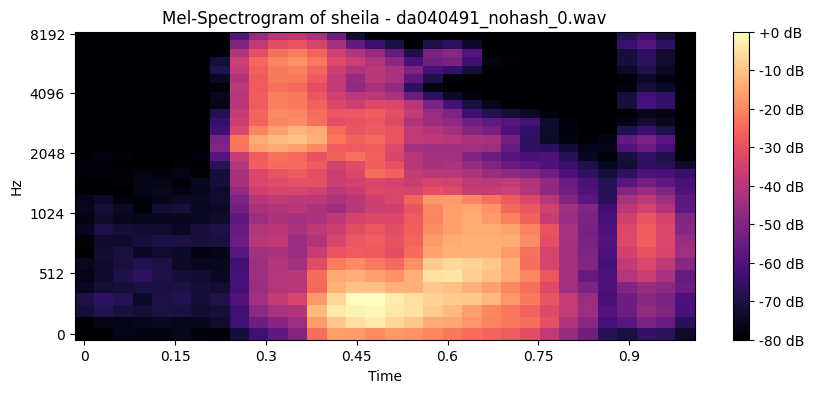

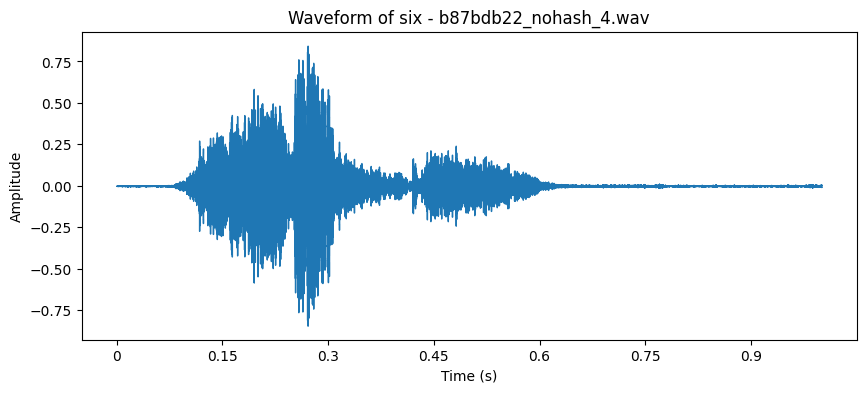

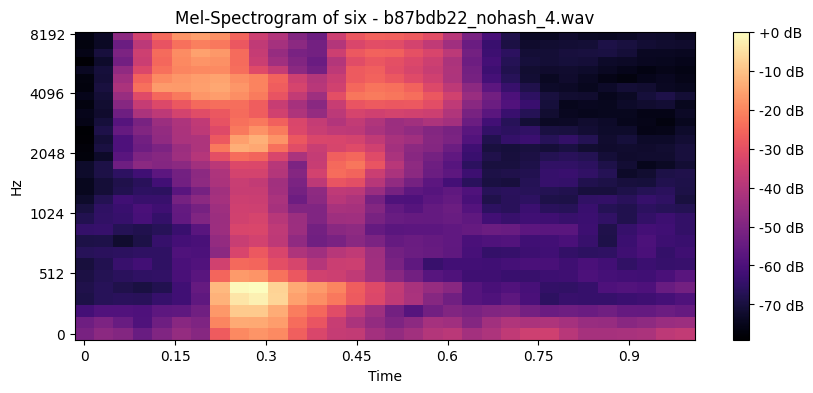

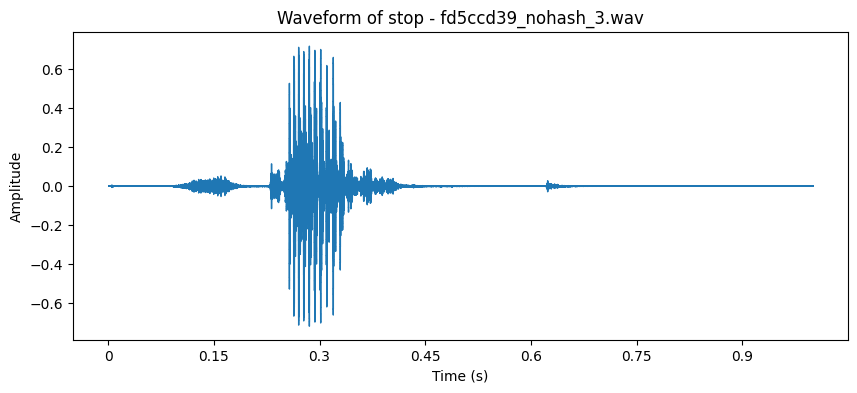

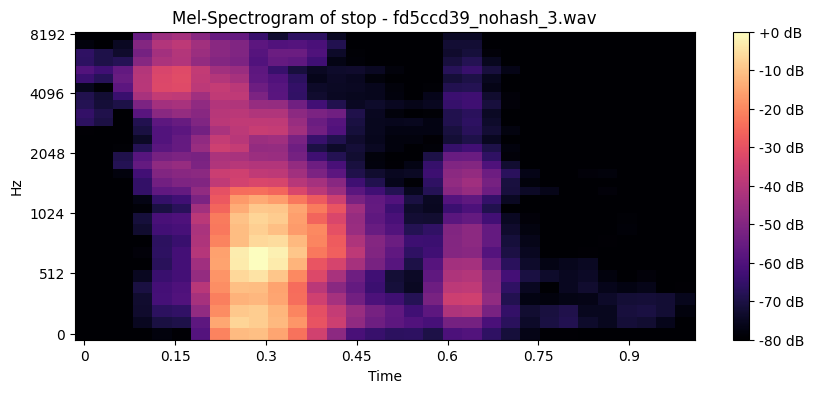

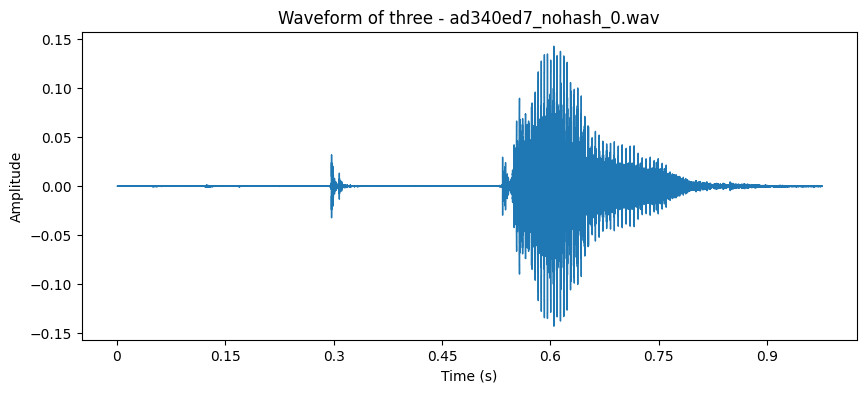

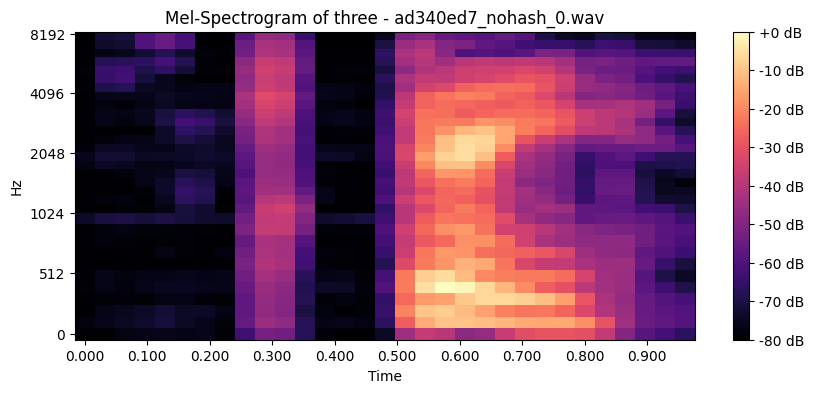

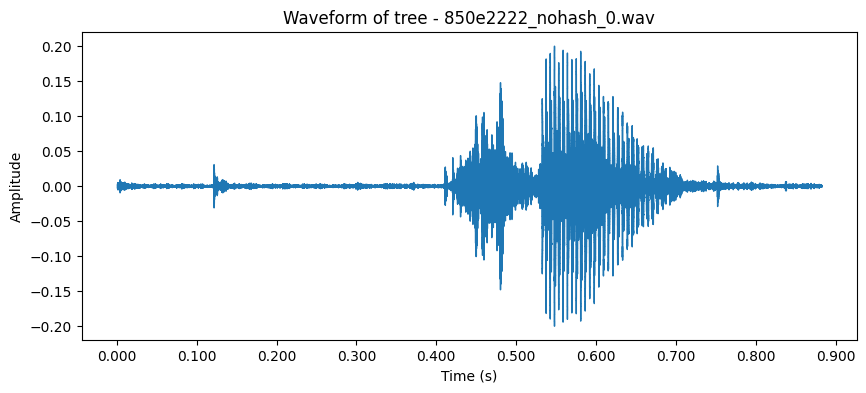

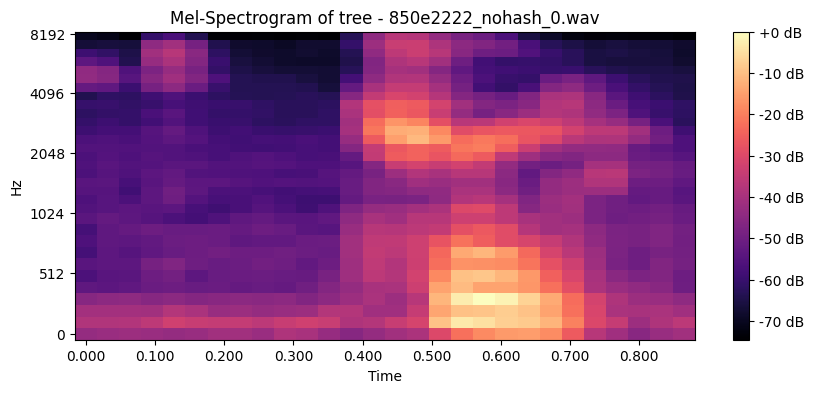

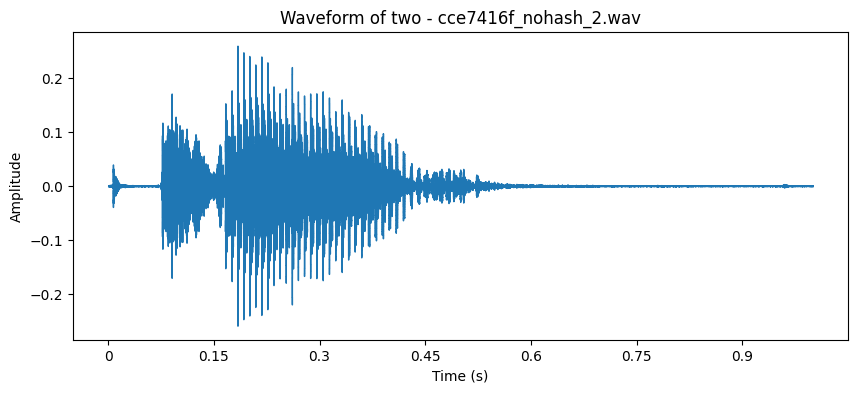

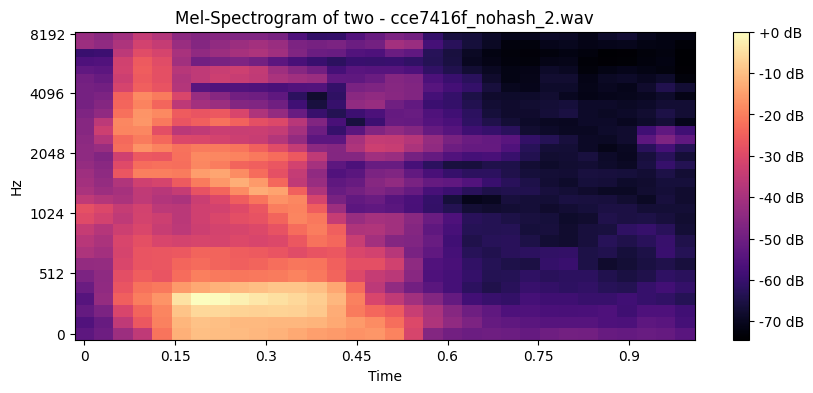

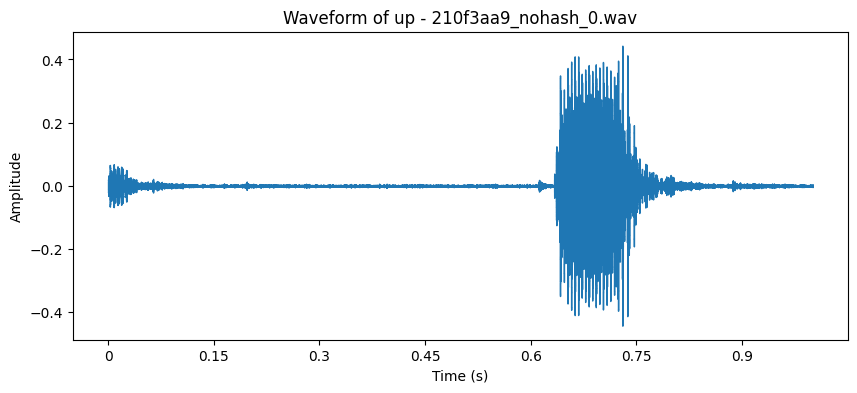

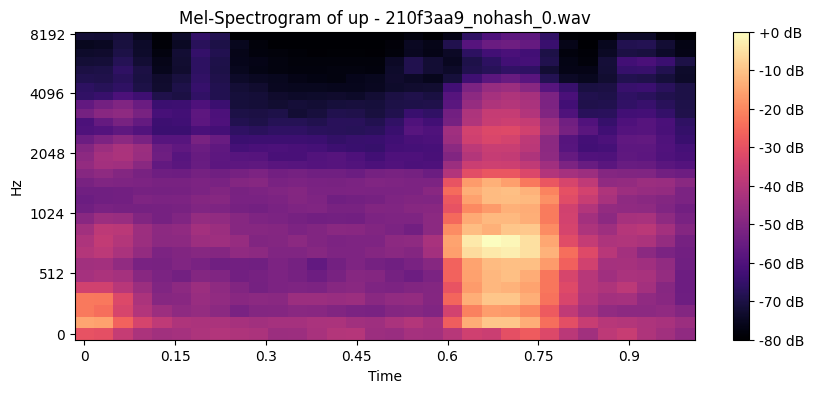

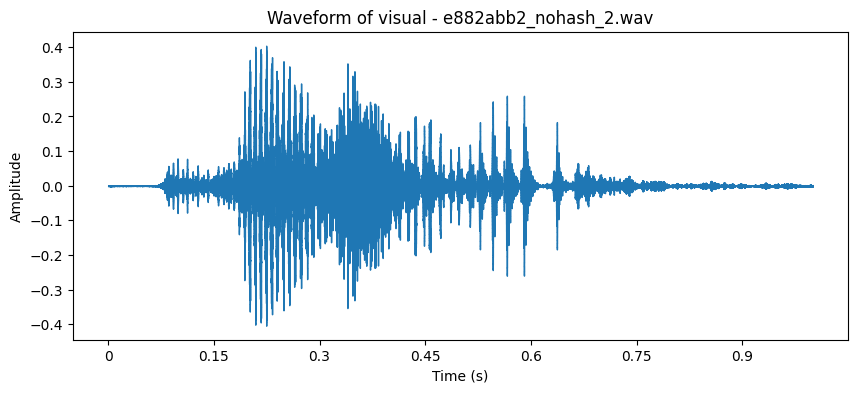

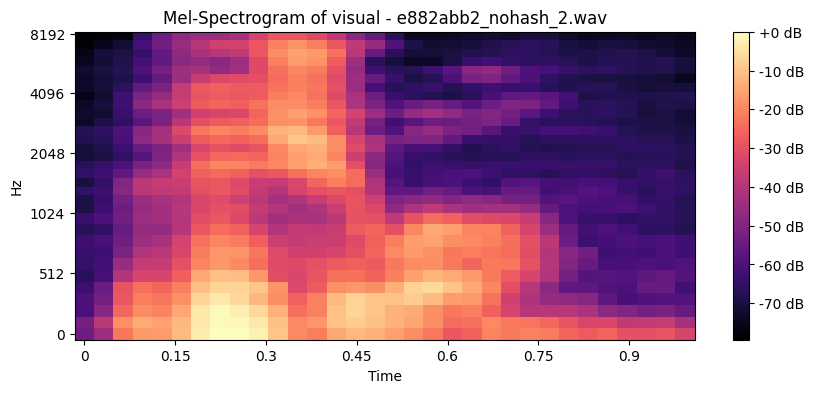

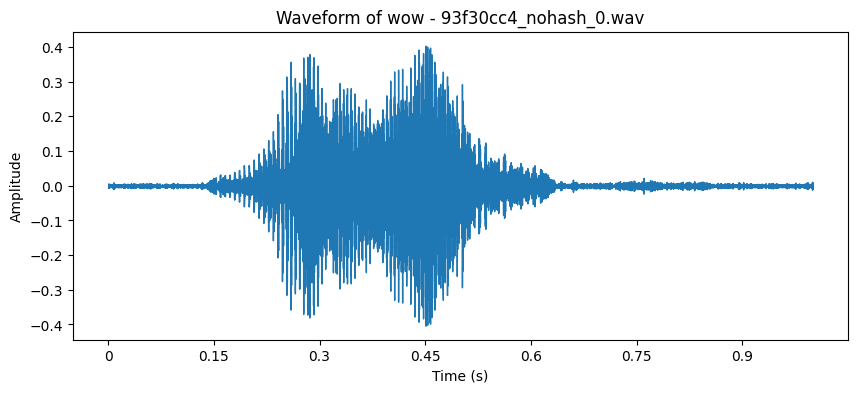

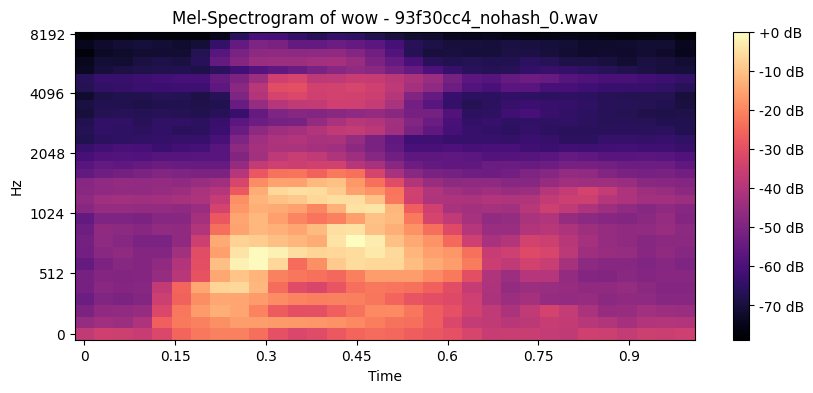

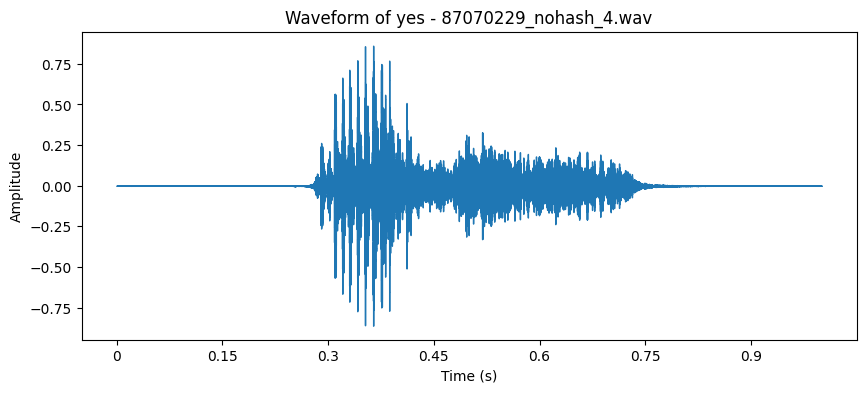

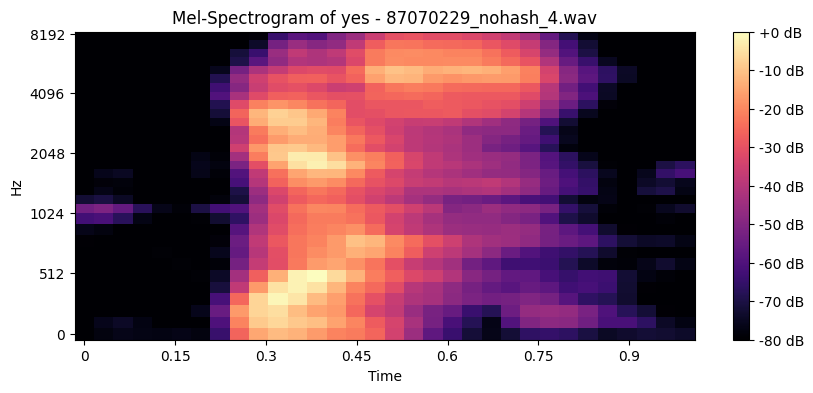

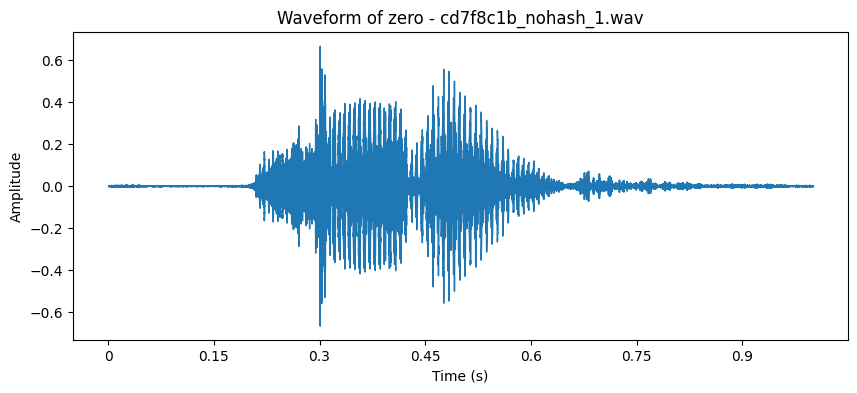

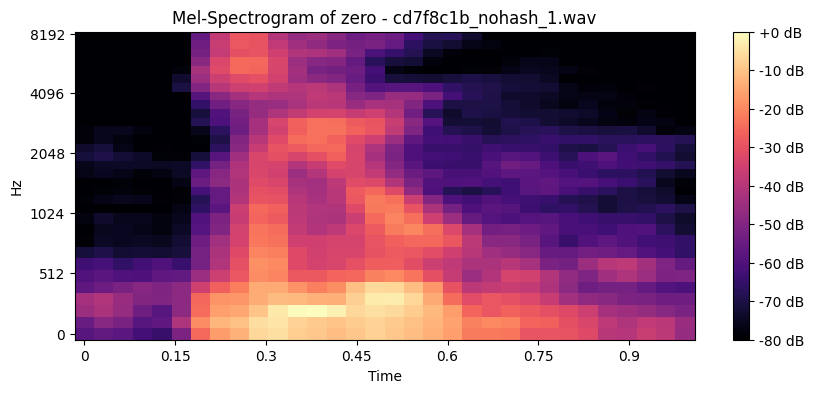

In [118]:
# Plot the class distribution
plot_class_distribution(labels, commands)

# Visualize sample waveforms and mel-spectrograms
visualize_samples(data_path, commands)


In [11]:
def add_noise(y, noise_factor=0.005):
    """Add random noise to audio data."""
    noise = np.random.randn(len(y))
    augmented_data = y + noise_factor * noise
    return augmented_data


SAMPLE_RATE = 22050
def shift_pitch(y, n_steps=2): # Removed sr argument
    """Shift pitch of the audio data."""
    return librosa.effects.pitch_shift(y, sr=SAMPLE_RATE, n_steps=n_steps) # sr is now a keyword argument




In [10]:
# Augment the dataset
augmented_data = []
augmented_labels = []

for i in range(len(train_data)):
    # Original data
    augmented_data.append(train_data[i])
    augmented_labels.append(train_labels[i])

    # Add noise
    noise_data = add_noise(train_data[i].flatten())
    augmented_data.append(noise_data.reshape(32, 32, 1))
    augmented_labels.append(train_labels[i])

    # Shift pitch
    pitch_data = shift_pitch(train_data[i].flatten()) # Removed SAMPLE_RATE argument
    augmented_data.append(pitch_data.reshape(32, 32, 1))
    augmented_labels.append(train_labels[i])

augmented_data = np.array(augmented_data)
augmented_labels = np.array(augmented_labels)

NameError: name 'train_data' is not defined

In [135]:
# Build the CNN model with Dropout layers and padding
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(commands), activation='softmax')  # Output layer
])


In [136]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [137]:
# Define early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [138]:
# Train the model
history = model.fit(augmented_data, augmented_labels, epochs=60,
                    validation_data=(val_data, val_labels),
                    batch_size=32, callbacks=[early_stopping])

Epoch 1/60

6351/6351 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.0534 - loss: 3.4579 - val_accuracy: 0.2671 - val_loss: 2.6572

Epoch 2/60

6351/6351 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.2018 - loss: 2.7549 - val_accuracy: 0.4645 - val_loss: 1.9413

Epoch 3/60

6351/6351 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.3155 - loss: 2.3292 - val_accuracy: 0.5729 - val_loss: 1.5165

Epoch 4/60

6351/6351 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.4051 - loss: 2.0079 - val_accuracy: 0.6418 - val_loss: 1.2624

Epoch 5/60

6351/6351 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.4670 - loss: 1.7948 - val_accuracy: 0.6881 - val_loss: 1.0917

Epoch 6/60

6351/6351 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.5127 - loss: 1.6451 - val_accuracy: 0.7240 - val_loss: 0.9604

Epoch 7/60

6351/6351 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.5469 - loss: 1.5318 - val_accuracy: 0.7457 - val_loss: 0.8784

Epoch 8/60

6351/6351 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0

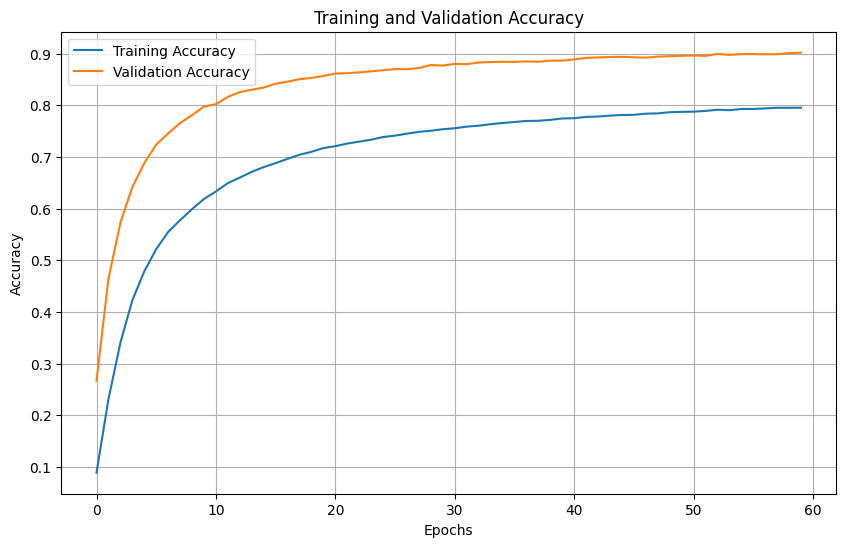

In [165]:
# Extract accuracy and validation accuracy from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

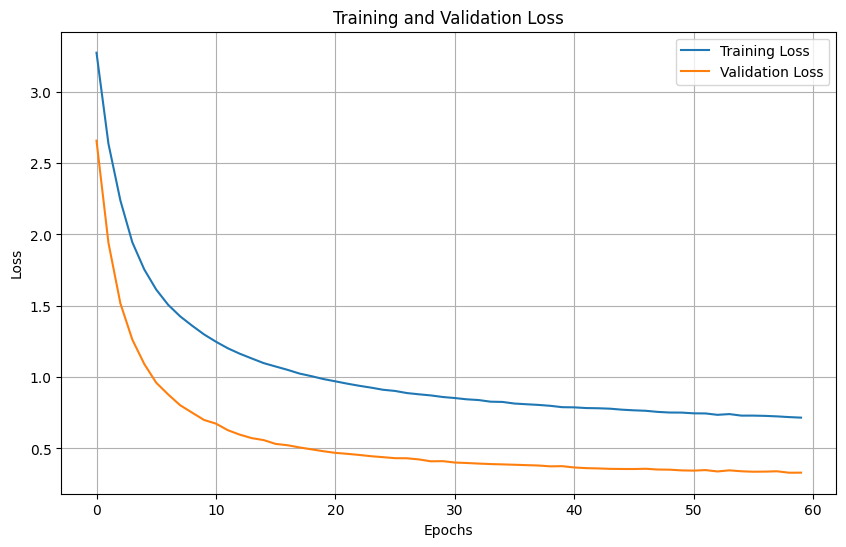

In [167]:
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [140]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_data, test_labels)
print(f"Test Accuracy after fine-tuning: {test_acc:.2f}")

662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9063 - loss: 0.3126

Test Accuracy after fine-tuning: 0.90


In [142]:
model.save("model_pratham.h5")

In [143]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)                   │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 2, 2, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 36)                  │           2,340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 445,166 (1.70 MB)

 Trainable params: 148,388 (579.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 296,778 (1.13 MB)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [70]:
pretrained_model = tf.keras.models.load_model(r'/kaggle/input/speech-audio/model_pratham.h5')

In [71]:
# Unfreeze the last few layers for fine-tuning
for layer in pretrained_model.layers[:3]:  # Freeze all layers till 3
    layer.trainable = False

for layer in pretrained_model.layers[3:]:  # Unfreeze the last n-3 layers
    layer.trainable = True

In [72]:
pretrained_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 2, 2, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 36)             │         2,340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,390 (579.65 KB)

 Trainable params: 148,068 (578.39 KB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 2 (12.00 B)

In [73]:
pretrained_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Adjust learning rate if necessary
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [74]:
new_data_path = "/kaggle/input/speech-audio/processed_recorded_audio/processed_recorded_audio"  # Path to the new dataset
new_audio_data, new_labels, new_commands = load_audio_files(new_data_path)

Commands: ['Backward', 'Bed', 'Bird', 'Dog', 'Down', 'Eight', 'Five', 'Follow', 'Forward', 'Four', 'Go', 'Happy', 'House', 'Learn', 'Left', 'Marvin', 'Nine', 'No', 'Off', 'On', 'One', 'Right', 'Seven', 'Sheila', 'Six', 'Stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [75]:
# Normalize data
new_audio_data = new_audio_data / 255.0

In [76]:
# Split new dataset into train, validation, and test sets
new_train_data, new_test_data, new_train_labels, new_test_labels = train_test_split(new_audio_data, new_labels, test_size=0.2, random_state=42)
new_train_data, new_val_data, new_train_labels, new_val_labels = train_test_split(new_train_data, new_train_labels, test_size=0.2, random_state=42)

In [77]:
print(new_train_data.shape)
print(new_train_labels.shape)
print(new_test_data.shape)
print(new_test_labels.shape)
print(new_val_data.shape)
print(new_val_labels.shape)


(984, 32, 32, 1)
(984,)
(308, 32, 32, 1)
(308,)
(246, 32, 32, 1)
(246,)


In [78]:
from tensorflow.keras.utils import to_categorical

new_train_labels = to_categorical(new_train_labels, num_classes=len(new_commands))
new_val_labels = to_categorical(new_val_labels, num_classes=len(new_commands))
new_test_labels = to_categorical(new_test_labels, num_classes=len(new_commands))

In [79]:
# # Convert labels to categorical format for training
# new_train_labels = tf.keras.utils.to_categorical(new_train_labels, num_classes=len(new_commands))
# new_val_labels = tf.keras.utils.to_categorical(new_val_labels, num_classes=len(new_commands))
# new_train_labels = tf.keras.utils.to_categorical(new_train_labels, num_classes=len(new_commands))

In [80]:
print(new_train_data.shape)
print(new_train_labels.shape)
print(new_test_data.shape)
print(new_test_labels.shape)
print(new_val_data.shape)
print(new_val_labels.shape)


(984, 32, 32, 1)
(984, 34)
(308, 32, 32, 1)
(308, 34)
(246, 32, 32, 1)
(246, 34)


In [81]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model checkpoint
checkpoint = ModelCheckpoint('fine_tuned_model.keras', save_best_only=True, monitor='val_loss')


In [82]:
new_train_labels.shape

(984, 34)

In [83]:
pretrained_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 2, 2, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 36)             │         2,340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,388 (579.64 KB)

 Trainable params: 148,068 (578.39 KB)

 Non-trainable params: 320 (1.25 KB)

In [39]:
from tensorflow.keras import layers, models
# x = pretrained_model.layers[-1].output 
# x = layers.Dense(34, activation='softmax')(x)
x = pretrained_model.layers[-2].output
# Add the new Dense layer for 34 classes
x = layers.Dense(34, activation='softmax')(x)

In [49]:
# from tensorflow.keras import layers, models

# # Assuming pretrained_model is your existing model
# x = pretrained_model.layers[-5].output

# # Add new Conv2D layers with padding='same'
# x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2))(x)
# x = layers.Dropout(0.25)(x)

# x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2))(x)
# x = layers.Dropout(0.25)(x)

# # Flatten the output to connect to Dense layers
# x = layers.Flatten()(x)

# # Add new Dense layer for 34 classes
# x = layers.Dense(34, activation='softmax')(x)

In [87]:
# from tensorflow.keras import layers, models

# # Start from the output of the last layer of the pretrained model
# x = pretrained_model.layers[-5].output

# # Add new Conv2D layers with padding='same' to keep output size the same
# x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
# x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
# x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
# x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)

# # Add MaxPooling2D layer (this will reduce the spatial dimensions)
# x = layers.MaxPooling2D((2, 2))(x)
# x = layers.Dropout(0.25)(x)

# # Add more Conv2D layers if needed
# x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)

# # Flatten the output to connect to Dense layers
# x = layers.Flatten()(x)

# # Add new Dense layer for 34 classes
# x = layers.Dense(34, activation='softmax')(x)


In [93]:
from tensorflow.keras import layers, models

# Start from the output of the last layer of the pretrained model
x = pretrained_model.layers[-6].output

# Add new Conv2D layers with unique names and padding='same' to keep output size the same
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv2d_new_1')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv2d_new_2')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv2d_new_3')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv2d_new_4')(x)

# Add MaxPooling2D layer (this will reduce the spatial dimensions)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Add more Conv2D layers with unique names if needed
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv2d_new_5')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv2d_new_6')(x)

# Flatten the output to connect to Dense layers
x = layers.Flatten()(x)

# Add new Dense layer for 34 classes
x = layers.Dense(34, activation='softmax', name='dense_new')(x)

In [94]:
# Define the new model
new_model = models.Model(inputs=pretrained_model.inputs, outputs=x)

In [95]:
new_model.summary()

Model: "functional_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_new_1 (Conv2D)           │ (None, 2, 2, 512)      │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_new_2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_new_3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_new_4 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_new_5 (Conv2D)           │ (None, 1, 1, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_new_6 (Conv2D)           │ (None, 1, 1, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_new (Dense)               │ (None, 34)             │         8,738 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,246,242 (35.27 MB)

 Trainable params: 9,245,922 (35.27 MB)

 Non-trainable params: 320 (1.25 KB)

In [41]:
input_tensor = pretrained_model.inputs

In [96]:
new_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',  # Or 'sparse_categorical_crossentropy' if labels are integers
                  metrics=['accuracy'])

In [98]:
history = new_model.fit(new_train_data, new_train_labels, epochs=50,  # Adjust epochs if necessary
                               validation_data=(new_val_data, new_val_labels),
                               batch_size=32,  # Adjust batch size if necessary
                               callbacks=[early_stopping])


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.0438 - loss: 3.4995 - val_accuracy: 0.0488 - val_loss: 3.5147
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0438 - loss: 3.4981 - val_accuracy: 0.0488 - val_loss: 3.5147
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0438 - loss: 3.4991 - val_accuracy: 0.0488 - val_loss: 3.5141
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0438 - loss: 3.4987 - val_accuracy: 0.0488 - val_loss: 3.5145
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0438 - loss: 3.5004 - val_accuracy: 0.0488 - val_loss: 3.5144
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0438 - loss: 3.5007 - val_accuracy: 0.0488 - val_loss: 3.5146
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0438 - loss: 3.4999 - val_accuracy: 0.0488 - val_loss: 3.5156
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0438 - loss: 3.5010 - val_accuracy: 0.0488 -